# Creating the tidal forcing

In [1]:
from roms_tools import Grid

We first create our grid object. Note that it is important to use the same grid throughout all the steps (i.e., creating tidal forcing, atmospheric forcing, initial conditions, etc.) to set up a consistent ROMS simulation. Here we use the following grid.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-10, center_lat=61, rot=-20
)

Given our grid, our goal is now to create the necessary tidal forcing fields to run a ROMS simulation.

For the time being, `ROMS-Tools` can only create tidal forcing from the `TPXO` atlas. A local copy of this atlas is found here:

In [3]:
filename = "/glade/derecho/scratch/bachman/ROMS_tools/DATASETS/tpxo9.v2a.nc"

We now create our tidal forcing for a model reference date of January 1st, 2000.

In [4]:
from roms_tools import TidalForcing

In [5]:
from datetime import datetime

In [6]:
model_reference_date = datetime(2000, 1, 1)

In [7]:
%%time

tidal_forcing = TidalForcing(
    grid=grid,
    source={"name": "TPXO", "filename": filename},
    ntides=10,  # number of constituents to consider. Maximum number is 14. Default is 10.
    model_reference_date=model_reference_date,  # reference date for the ROMS simulation. Default is datetime(2000, 1, 1).
    allan_factor=2.0,  # Allan factor. Default is 2.0.
)

CPU times: user 18.7 s, sys: 4.51 s, total: 23.2 s
Wall time: 33.2 s


To see the values of the tidal forcing variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

In [8]:
tidal_forcing.ds

<xarray.Dataset> Size: 3MB
Dimensions:  (ntides: 10, eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101)
Coordinates:
    omega    (ntides) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 83kB 52.04 52.02 52.01 ... 65.87 65.76
    lon_rho  (eta_rho, xi_rho) float64 83kB 331.3 331.5 331.8 ... 18.5 18.77
Dimensions without coordinates: ntides, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 416kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    ssh_Im   (ntides, eta_rho, xi_rho) float32 416kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    pot_Re   (ntides, eta_rho, xi_rho) float32 416kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    pot_Im   (ntides, eta_rho, xi_rho) float32 416kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    u_Re     (ntides, eta_rho, xi_u) float32 412kB dask.array<chunksize=(4, 102, 101), meta=np.ndarray>
    u_Im     (ntides, eta_rho, xi_u) float32 412kB dask.array<chunksize=(4, 102, 101), meta=np.ndarray>
    v_Re     (ntides, eta_v, xi_rho) float32 412kB dask.array<chunksize=(4, 101, 102), meta=np.ndarray>
    v_Im     (ntides, eta_v, xi_rho) float32 412kB dask.array<chunksize=(4, 101, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    0.1.dev44
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00
    allan_factor:          2.0

We can also plot any of the tidal forcing fields via the `.plot` method.

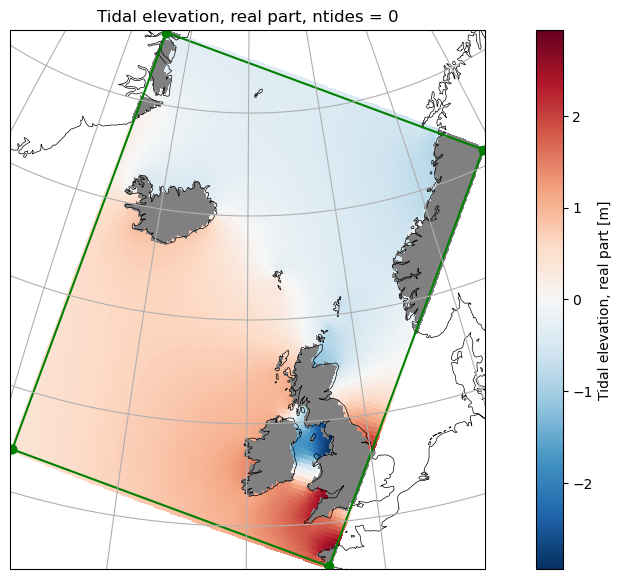

In [9]:
tidal_forcing.plot("ssh_Re", ntides=0)

Finally, we can save our tidal forcing as a netCDF file via the `.save` method.

In [10]:
filepath = "/glade/derecho/scratch/noraloose/forcing/my_tidal_forcing.nc"

In [11]:
%time tidal_forcing.save(filepath)

CPU times: user 24 s, sys: 17.5 s, total: 41.5 s
Wall time: 47.9 s


We can also export the parameters of our `TidalForcing` object to a YAML file.

In [12]:
yaml_filepath = "/glade/derecho/scratch/noraloose/forcing/my_tidal_forcing.yaml"

In [13]:
tidal_forcing.to_yaml(yaml_filepath)

In [14]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev44
---
Grid:
  center_lat: 61
  center_lon: -10
  hmin: 5.0
  nx: 100
  ny: 100
  rmax: 0.2
  rot: -20
  size_x: 1800
  size_y: 2400
  smooth_factor: 8
  topography_source: ETOPO5
TidalForcing:
  allan_factor: 2.0
  model_reference_date: '2000-01-01T00:00:00'
  ntides: 10
  source:
    filename: /glade/derecho/scratch/bachman/ROMS_tools/DATASETS/tpxo9.v2a.nc
    name: TPXO



## Creating tidal forcing from an existing YAML file

In [15]:
%time the_same_tidal_forcing = TidalForcing.from_yaml(yaml_filepath)

CPU times: user 11.6 s, sys: 8.83 s, total: 20.4 s
Wall time: 24 s


In [16]:
the_same_tidal_forcing.ds

<xarray.Dataset> Size: 3MB
Dimensions:  (ntides: 10, eta_rho: 102, xi_rho: 102, xi_u: 101, eta_v: 101)
Coordinates:
    omega    (ntides) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 83kB 52.04 52.02 52.01 ... 65.87 65.76
    lon_rho  (eta_rho, xi_rho) float64 83kB 331.3 331.5 331.8 ... 18.5 18.77
Dimensions without coordinates: ntides, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 416kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    ssh_Im   (ntides, eta_rho, xi_rho) float32 416kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    pot_Re   (ntides, eta_rho, xi_rho) float32 416kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    pot_Im   (ntides, eta_rho, xi_rho) float32 416kB dask.array<chunksize=(4, 102, 102), meta=np.ndarray>
    u_Re     (ntides, eta_rho, xi_u) float32 412kB dask.array<chunksize=(4, 102, 101), meta=np.ndarray>
    u_Im     (ntides, eta_rho, xi_u) float32 412kB dask.array<chunksize=(4, 102, 101), meta=np.ndarray>
    v_Re     (ntides, eta_v, xi_rho) float32 412kB dask.array<chunksize=(4, 101, 102), meta=np.ndarray>
    v_Im     (ntides, eta_v, xi_rho) float32 412kB dask.array<chunksize=(4, 101, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    0.1.dev44
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00
    allan_factor:          2.0